<a href="https://colab.research.google.com/github/robinvandernoord/thesis/blob/master/Thesis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# get gpu specs
!nvidia-smi
# Tesla K80  = bad
# Tesla T4   = good
# Tesla P100 = good
# Tesla V100 = very good

Fri May 28 09:00:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install simpletransformers pyyaml --upgrade

In [1]:
# imports

# default libs:
import csv
import os
import numpy as np
import pandas as pd
import random
import sys
import warnings
import datetime
import yaml
import unicodedata
import requests
import math
import re
import logging
import collections
from collections import defaultdict
from pprint import pprint

# preproc.
import nltk
import nltk.classify
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Dummy, SVM and metrics: 
import sklearn.metrics
from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
sb = sns

# BiLSTM
import gensim
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# BERT
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# muting some output
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
logging.basicConfig(level=logging.WARNING)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# NLTK models
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# colab to save models
from google.colab import drive
drive.mount("/content/gdrive")
DRIVE = '/content/gdrive/MyDrive/thesis/'

Mounted at /content/gdrive


## Preprocessing Functions:

In [2]:
# https://github.com/clips/hades
HADES_URL = 'https://raw.githubusercontent.com/clips/hades/master'

with open('dictfeaturizer.py' ,'w') as py_f, open('dictionary.csv', 'w') as csv_f:
    py_f.write(requests.get(f"{HADES_URL}/dictfeaturizer.py").text)
    # csv_f.write(requests.get(f"{HADES_URL}/original.csv").text)
    csv_f.write(requests.get(f"{HADES_URL}/expanded.csv").text)

from dictfeaturizer import DictFeaturizer

dict_features = DictFeaturizer.load('dictionary.csv')

In [3]:
# preprocessing

ASCII_RE = re.compile(r'[^A-Za-z\s]')
PUNCTUATION_RE = re.compile(r'[\.,!?\-|:;()]')
USERNAME_RE = re.compile(r'@(\w){1,15}')
URL_RE = re.compile(r'https?://t.co/\w+')
NUMBER_RE = re.compile(r'([0-9,.])+')

stop_words = set(stopwords.words("dutch")) 
# lemmatizer = WordNetLemmatizer()

# pre-tokenization changes:

def emoji(raw_text):
    # run this BEFORE clean_tweet!
    return "".join([f"{unicodedata.name(char)} " if not char.isascii() else char for char in raw_text])

def clean_tweet(raw_tweet):
    # Remove non-letters and Convert to lower case
    return ASCII_RE.sub(" ", raw_tweet)

def remove_punctuation(raw_tweet):
    return PUNCTUATION_RE.sub(" ", raw_tweet)

def remove_numbers(raw_tweet):
    return NUMBER_RE.sub("[NUMBER]", raw_tweet)

def remove_mentions(raw_tweet, full=False):
    if full:
        return USERNAME_RE.sub("[USER]", raw_tweet)
    else:
        return raw_tweet.replace('@', '')

def remove_mentions_full(r):
    return remove_mentions(r,1)

def remove_urls(raw_tweet):
    return URL_RE.sub("[URL]", raw_tweet)

def remove_hashtags(raw_tweet):
    return raw_tweet.replace('#', '')

# words -> tokens

def tokenize(words):
    # seems to work better than the tweettokenizer
    return words.split(' ')


tt = nltk.tokenize.TweetTokenizer()
def tokenize_nltk(words):
    return tt.tokenize(words)


# token preprocessing

stemmer = nltk.stem.snowball.DutchStemmer()
def stem(tokens):
    return [stemmer.stem(word) for word in tokens]

# features

def bag_of_words(tokens):
	'''
	>>> bag_of_words(['the', 'quick', 'brown', 'fox'])
	{'quick': True, 'brown': True, 'the': True, 'fox': True}
	'''
	return {word: True for word in tokens if word}

def bag_of_bigrams_words(tokens, score_fn=BigramAssocMeasures.chi_sq, n=200):
	'''
	>>> bag_of_bigrams_words(['the', 'quick', 'brown', 'fox'])
	{'brown': True, ('brown', 'fox'): True, ('the', 'quick'): True, 'quick': True, ('quick', 'brown'): True, 'the': True, 'fox': True}
	'''
	try:
		bigram_finder = BigramCollocationFinder.from_words(tokens)
		bigrams = bigram_finder.nbest(score_fn, n)
	except:
		bigrams = []
	return bag_of_words(tokens + bigrams)

def counter(tokens):
    return collections.Counter(tokens)

def hateful_feature_scores(tokens):
    return dict_features.transform(tokens)

def bag_of_hateful_words(tokens, count=False):
    prefix = "hateful__"

    freq_dict = collections.Counter(tokens)
    features = {}

    for group, wordlists in dict_features.dict.items():

        normal, wildcards = wordlists

        keys = set(freq_dict.keys())

        features.update({f"{prefix}{k}": (freq_dict[k] if count else True) for k in normal & keys})
        if wildcards:
            features.update({f"{prefix}{k}": (freq_dict[k] if count else True) for k in keys - normal
                                    if wildcards.match(k)})
    
    return features

def hateful_words_counter(tokens):
    return bag_of_hateful_words(tokens, True)

def combine_features(*funcs):
    # used to combine e.g. bag_of_hateful_words with bag_of_words
    def wrapper(tokens):
        result = {}
        for func in funcs:
            result.update(func(tokens))
        return result
    return wrapper

def preprocess(tweet, pipeline):
    for step in pipeline:
        tweet = step(tweet)
    return tweet

In [4]:
# metrics: confusion matrix and classification report (with right labels)

def confusion(y_true, y_pred):
    unique_label = np.unique([y_true, y_pred])
    return pd.DataFrame(
        sklearn.metrics.confusion_matrix(y_true, y_pred, labels=unique_label), 
        index=['{:}'.format(LABELS[int(x)]) for x in unique_label], # true rows
        columns=['{:}'.format(LABELS[int(x)]) for x in unique_label] # pred cols
    )

def classification_report(y_true, y_pred):
    return sklearn.metrics.classification_report(y_true, y_pred, digits=4, target_names=LABELS, labels=list(range(len(LABELS))))

In [5]:
# helper functions to create output for in thesis

def confusion_heatmap(conf_matrix, colors=None):
    # show heatmap for confusion matrix
    dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=colors, xticklabels=LABELS, yticklabels=LABELS)
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label")
    plt.show()

def parse(first, *extra, only=False):
    # since I stored the model results in strings, this model parses
    # the confusion matrix from this string
    y_pred = []
    y_true = []

    for string in [first, *extra]:
        if 'confusion:' in string:
            string = string.split('confusion:', 1)[-1]

        numbers = re.findall(r'\d+', string)
        xlab = 0
        ylab = 0
        for ind, number in enumerate(numbers):
            xlab = ind % 4
            ylab = math.floor(ind / 4)
            
            y_true.extend([ylab] * int(number))
            y_pred.extend([xlab] * int(number))

    return y_true, y_pred

def parse_report(first, *extra):
    # make average report in latex table format
    numbers = [0] * (16+8+2)
    all = [first, *extra]
    for x in all:
        if 'confusion:' in x:
            x = x.split('confusion:', 1)[0]
        index = 0
        for number, _ in re.findall(r'((\d|\.)+)', x)[1:]:
            numbers[index] += float(number)
            index += 1
    
    vals =  [int(n/len(all)) if int(n/len(all)) == n/len(all) else round(n/len(all), 4) for n in numbers]

    print("""        & precision & recall & f1-score & support \\\\ \\hline
INDIVIDUAL   & {0}         & {1}      & {2}        & {3}      \\\\
GROUP        & {4}         & {5}      & {6}        & {7}                      \\\\
OTHER        & {8}         & {9}      & {10}       & {11}                     \\\\
NOT          & {12}        & {13}     & {14}       & {15} \\\\
accuracy     &           &        & {16}       & {17}                     \\\\
macro avg    & {18}        & {19}     & {20}       & {21}                     \\\\
weighted avg & {22}        & {23}     & {24}       & {25}                                   
             """.format(*vals))

# Loading Data

In [6]:
# upload data
from google.colab import files
uploaded = files.upload()

# upload dev_final.csv, test_final.csv and train_final.csv here

Saving dev_final.csv to dev_final.csv
Saving test_final.csv to test_final.csv
Saving train_final.csv to train_final.csv


In [7]:
LABELS = ["INDIVIDUAL", "GROUP", "OTHER", "NOT"]
def load(fn):
    # load data - final
    full_data = []

    with open(fn, encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')

        for index, line in enumerate(reader):
            if line.get('explicitness', 'NOT').strip() != 'NOT':
                full_data.append([
                                  line['text'], 
                                  LABELS.index(line['target'].strip()),
                                  ])

    df_full = pd.DataFrame(full_data)
    df_full.columns = ["text", "labels"]
    return df_full

train_df = load('train_final.csv')
dev_df = test_df = load('dev_final.csv') # aliased to test_df since I used that
eval_df = load('test_final.csv') # called eval to make sure it is never used instead of dev

In [8]:
LABELS = ["INDIVIDUAL", "GROUP", "OTHER", "NOT"]
def load_for_vis(fn):
    # load data - including NOT offensive and additional fields for visualization
    full_data = []

    with open(fn, encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')

        for index, line in enumerate(reader):
            full_data.append([
                                line['text'], 
                                line['target'].strip(),
                                line['explicitness'],
                                line['abusive'],
                                ])

    df_full = pd.DataFrame(full_data)
    df_full.columns = ["text", "labels", "explicit", "abusive"]

    return df_full

train_df_vis = load_for_vis('train_final.csv')
dev_df_vis = test_df_vis = load_for_vis('dev_final.csv') # aliased to test_df since I used that

eval_df_vis = load_for_vis('test_final.csv') # called eval to make sure it is never used instead of dev

# full:
df_vis = pd.concat([train_df_vis, test_df_vis, dev_df_vis])

## Visualizing

In [9]:
def hist_plot(l, i, label):
    # helper to create a histogram with the number above it
    plt.hist(l,
            bins=2,
            color=colors[i], 
            label=label,
            )
    
    # https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
    plt.annotate(l.count(),
               xy = (i + 0.25, l.count()),   # top left corner of the histogram bar
               xytext = (0,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

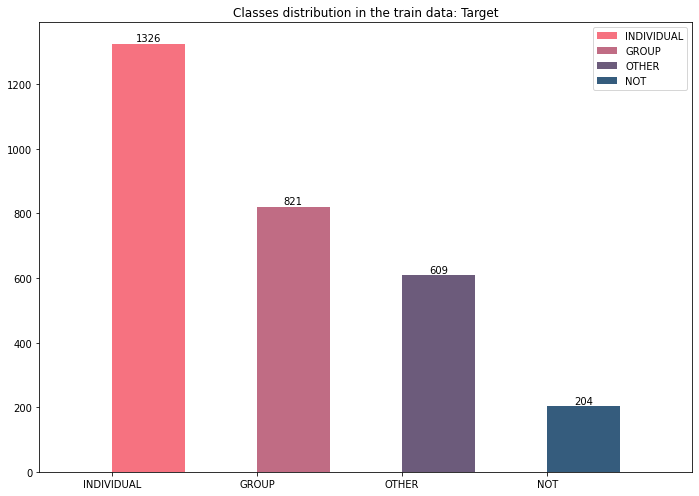

In [10]:
# plot histogram for Target distribution

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)

colors = ['#F67280', '#C06C84', '#6C5B7B', '#355C7D']

for i, label in enumerate(LABELS):
    l = df_vis[df_vis.labels == label].labels
    hist_plot(l, i, label)

plt.title('Classes distribution in the train data: Target')
plt.xlim(-0.5, 4)
plt.legend()
plt.show()

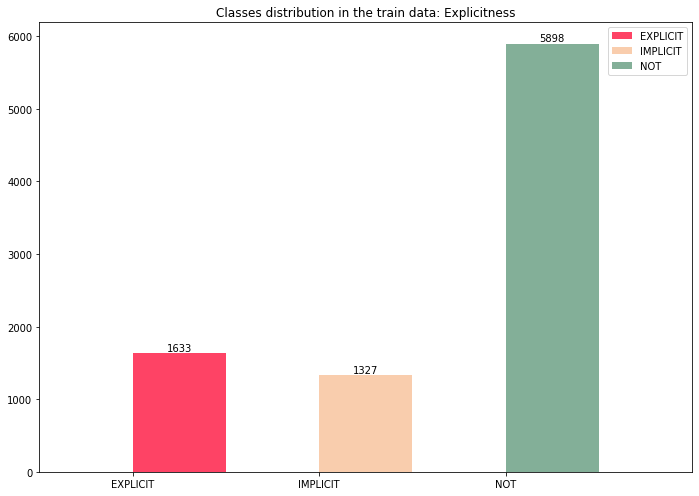

In [11]:
# plot histogram for Explicitness distribution

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)

colors = ['#FE4365', '#F9CDAD', '#83AF98']

for i, label in enumerate(['EXPLICIT', 'IMPLICIT', 'NOT']):
    l = df_vis[df_vis.explicit == label].explicit
    hist_plot(l, i, label)

plt.title('Classes distribution in the train data: Explicitness')
plt.xlim(-0.5, 3)
plt.legend()
plt.show()

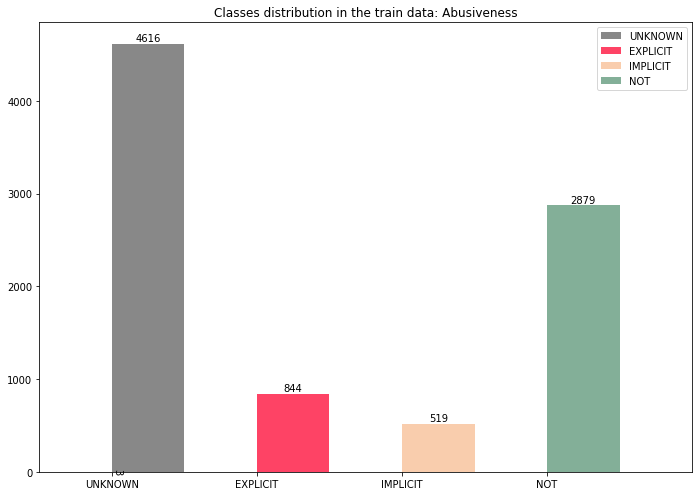

In [12]:
# plot histogram for Abusiveness distribution

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)

colors = ['#888888', '#FE4365', '#F9CDAD', '#83AF98']

for i, label in enumerate(['UNKNOWN', 'EXPLICIT', 'IMPLICIT', 'NOT']):
    l = df_vis[df_vis.abusive == label].abusive
    hist_plot(l, i, label)

plt.title('Classes distribution in the train data: Abusiveness')
plt.xlim(-0.5, 4)
plt.legend()

plt.text(0, 0+0.05, 3, fontsize=10, rotation=-90) # x,y,str

plt.show()

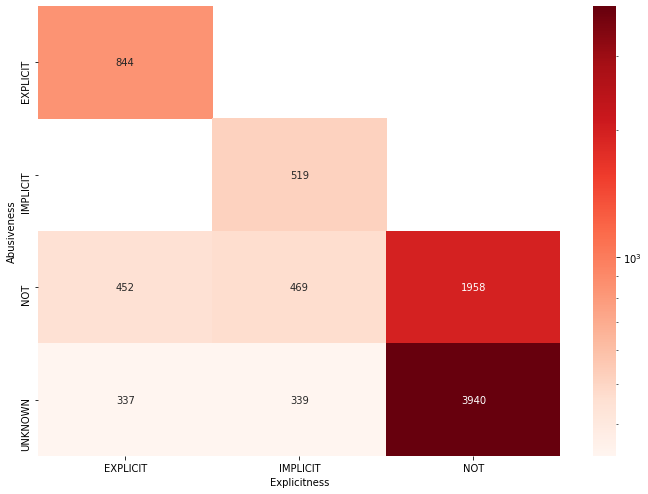

In [14]:
# Heatmap of Expl. vs Abus.

result = df_vis.groupby(["explicit", "abusive"]).size().unstack(level=0).replace(np.NaN, 0)

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)

h = sb.heatmap(result, annot=True, cmap="Reds", fmt='g', norm=LogNorm())

plt.xlabel("Explicitness") 
plt.ylabel("Abusiveness") 
plt.show()

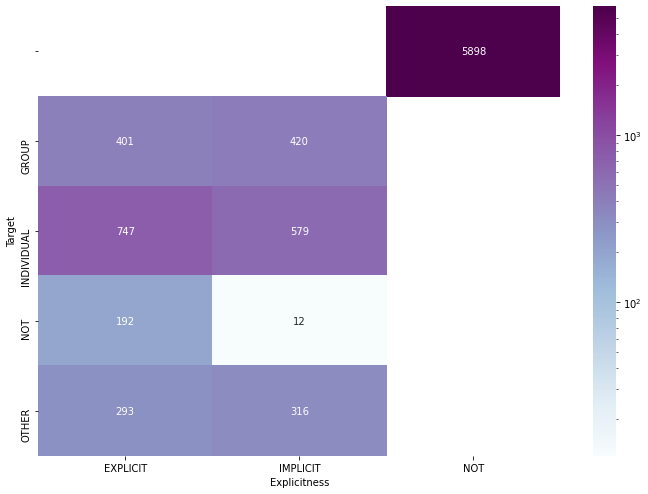

In [15]:
# Heatmap of Explic. vs Target

result = df_vis.groupby(["explicit", "labels"]).size().unstack(level=0).replace(np.NaN, 0)

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)

h = sb.heatmap(result, annot=True, cmap="BuPu", fmt='g', norm=LogNorm())

plt.xlabel("Explicitness") 
plt.ylabel("Target") 
plt.show()

# Dummy Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

0.489247311827957 0.4546332046332046 INDIVIDUAL
dev:               precision    recall  f1-score   support

  INDIVIDUAL     0.4892    1.0000    0.6570        91
       GROUP     0.0000    0.0000    0.0000        49
       OTHER     0.0000    0.0000    0.0000        37
         NOT     0.0000    0.0000    0.0000         9

    accuracy                         0.4892       186
   macro avg     0.1223    0.2500    0.1643       186
weighted avg     0.2394    0.4892    0.3215       186

test:               precision    recall  f1-score   support

  INDIVIDUAL     0.4546    1.0000    0.6251       471
       GROUP     0.0000    0.0000    0.0000       321
       OTHER     0.0000    0.0000    0.0000       176
         NOT     0.0000    0.0000    0.0000        68

    accuracy                         0.4546      1036
   macro avg     0.1137    0.2500    0.1563      1036
weighted avg     0.2067    0.4546    0.2842      1036



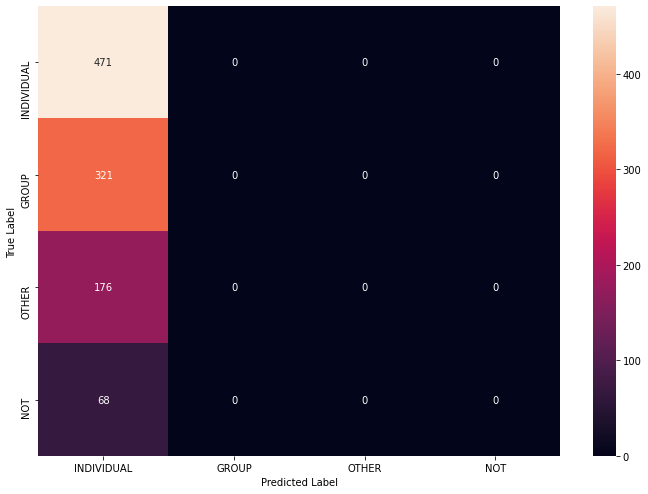

In [16]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_df.text, train_df.labels)
print(dummy.score(test_df.text, test_df.labels), dummy.score(eval_df.text, eval_df.labels), LABELS[np.argmax(dummy.class_prior_, axis=-1)])

print('dev:',classification_report(test_df.labels, dummy.predict(test_df.text)))
print('test:',classification_report(eval_df.labels, dummy.predict(eval_df.text)))

x = confusion_matrix(eval_df.labels, dummy.predict(eval_df.text), )
confusion_heatmap(x)

In [17]:
dummy_dev = """
dev:               precision    recall  f1-score   support

  INDIVIDUAL     0.4892    1.0000    0.6570        91
       GROUP     0.0000    0.0000    0.0000        49
       OTHER     0.0000    0.0000    0.0000        37
         NOT     0.0000    0.0000    0.0000         9

    accuracy                         0.4892       186
   macro avg     0.1223    0.2500    0.1643       186
weighted avg     0.2394    0.4892    0.3215       186
"""
dummy_test = """
test:               precision    recall  f1-score   support

  INDIVIDUAL     0.4546    1.0000    0.6251       471
       GROUP     0.0000    0.0000    0.0000       321
       OTHER     0.0000    0.0000    0.0000       176
         NOT     0.0000    0.0000    0.0000        68

    accuracy                         0.4546      1036
   macro avg     0.1137    0.2500    0.1563      1036
weighted avg     0.2067    0.4546    0.2842      1036
"""

parse_report(dummy_test)

        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.4546         & 1      & 0.6251        & 471      \\
GROUP        & 0         & 0      & 0        & 321                      \\
OTHER        & 0         & 0      & 0       & 176                     \\
NOT          & 0        & 0     & 0       & 68 \\
accuracy     &           &        & 0.4546       & 1036                     \\
macro avg    & 0.1137        & 0.25     & 0.1563       & 1036                     \\
weighted avg & 0.2067        & 0.4546     & 0.2842       & 1036                                   
             


# SVM

In [ ]:
def high_information_words(labelled_words, score_fn=BigramAssocMeasures.chi_sq, min_score=5):
    # source: https://github.com/PacktPublishing/Natural-Language-Processing-Python-and-NLTK/blob/master/Module%202/Chapter%207/7853OS_07_Codes/featx.py
	word_fd = nltk.FreqDist()
	label_word_fd = nltk.ConditionalFreqDist()
	
	for label, words in labelled_words:
		for word in words:
			word_fd[word] += 1
			label_word_fd[label][word] += 1
	
	n_xx = label_word_fd.N()
	high_info_words = set()
	
	for label in label_word_fd.conditions():
		n_xi = label_word_fd[label].N()
		word_scores = collections.defaultdict(int)
		
		for word, n_ii in label_word_fd[label].items():
			n_ix = word_fd[word]
			score = score_fn(n_ii, (n_ix, n_xi), n_xx)
			word_scores[word] = score
		
		bestwords = [word for word, score in word_scores.items() if score >= min_score]
		high_info_words |= set(bestwords)
	
	print(high_info_words)
	return high_info_words

def high_info_feats(feats, min_sc=7):
    """
    returns hi_feats, a list containing tuples (bag_dict, category_string)
    makes sure the feats contain bags of words with only high info words in them

    Source: V. Zwart, R. van der Noord and F. van den Berg
    """
    labels_dict = {l: i for l, i in enumerate(LABELS)}

    hi_feats = []

    # Convert the formatting of our features to that required by high_information_words
    words = defaultdict(list)
    for label in labels_dict:
        words[label] = []

    for feat in feats:
        label = feat[1]
        bag = feat[0]
        for w in bag.keys():
            words[label].append(w)

    # Calculate high information words
    labelled_words = [(label, words[label]) for label in labels_dict]
    high_info_words = set(high_information_words(labelled_words, min_score=min_sc))

    # Use the high information words to create high information features
    for feat in feats:
        category = feat[1]
        bag = feat[0]
        hi_bag = dict()
        for w in bag.keys():
            if w in high_info_words:  # ensure the words in each bag are only high info words
                hi_bag[w] = bag[w]
        hi_feats.append((hi_bag, category))  # add the new bag dict and category to the features list

    return hi_feats

In [ ]:
svm_pipeline = [
                # emoji,
                str.lower,
                # clean_tweet,
                remove_mentions,
                remove_urls,
                remove_hashtags,
                # remove_punctuation,
                remove_numbers,

                # tokenize_nltk,
                # tokenize,
                word_tokenize,
                
                # remove_stop_words,
                # stem,
                
                # counter,
                # bag_of_words,
                # bag_of_bigrams_words,
                # bag_of_hateful_words,
                # hateful_words_counter,
                combine_features(bag_of_bigrams_words, bag_of_hateful_words),
]

# baseline:
# svm_pipeline = [tokenize, bag_of_words]

def svm_preprocess(text):
    return preprocess(text, svm_pipeline)

In [ ]:
train = []
for index, row in train_df.iterrows():
    train.append((svm_preprocess(row['text']), row['labels']))

test = []
for index, row in test_df.iterrows():
    test.append((svm_preprocess(row['text']), row['labels']))

eval = []
for index, row in eval_df.iterrows():
    eval.append((svm_preprocess(row['text']), row['labels']))

train_hifeats = train
test_hifeats = test

# use high-info:
# train_hifeats = high_info_feats(train, 0.05)
# test_hifeats = high_info_feats(test, 0.05)

In [ ]:
# Train the classifier
classifier = SklearnClassifier(LinearSVC())
classifier._vectorizer.sort = False # bigrams
model = classifier.train(train_hifeats)

def evaluation(classifier, test):
    y_prob = classifier.classify_many([t[0] for t in test])
    y_real = [t[1] for t in test]
    print(classification_report(y_real, y_prob))
    print(confusion(y_real, y_prob))
    return nltk.classify.accuracy(classifier, test)

# dev:
print(evaluation(model, test_hifeats))

              precision    recall  f1-score   support

  INDIVIDUAL     0.7595    0.6593    0.7059        91
       GROUP     0.4127    0.5306    0.4643        49
       OTHER     0.4286    0.4865    0.4557        37
         NOT     0.5000    0.1111    0.1818         9

    accuracy                         0.5645       186
   macro avg     0.5252    0.4469    0.4519       186
weighted avg     0.5897    0.5645    0.5671       186

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL          60     20     11    0
GROUP               11     26     11    1
OTHER                4     15     18    0
NOT                  4      2      2    1
0.5645161290322581


In [ ]:
# test:
print(evaluation(model, eval))

              precision    recall  f1-score   support

  INDIVIDUAL     0.6414    0.7558    0.6940       471
       GROUP     0.5907    0.5171    0.5515       321
       OTHER     0.3309    0.2614    0.2921       176
         NOT     0.3443    0.3088    0.3256        68

    accuracy                         0.5685      1036
   macro avg     0.4768    0.4608    0.4658      1036
weighted avg     0.5535    0.5685    0.5574      1036

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         356     66     30   19
GROUP               86    166     56   13
OTHER               82     40     46    8
NOT                 31      9      7   21
0.5685328185328186


In [ ]:
# saved scores:
svm_base = """baseline report
              precision    recall  f1-score   support

  INDIVIDUAL     0.6414    0.7558    0.6940       471
       GROUP     0.5907    0.5171    0.5515       321
       OTHER     0.3309    0.2614    0.2921       176
         NOT     0.3443    0.3088    0.3256        68

    accuracy                         0.5685      1036
   macro avg     0.4768    0.4608    0.4658      1036
weighted avg     0.5535    0.5685    0.5574      1036

confusion:
            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         356     66     30   19
GROUP               86    166     56   13
OTHER               82     40     46    8
NOT                 31      9      7   21
"""

svm_improved = """improved report
            precision    recall  f1-score   support

  INDIVIDUAL     0.6755    0.8089    0.7362       471
       GROUP     0.6763    0.5857    0.6277       321
       OTHER     0.4017    0.2670    0.3208       176
         NOT     0.3377    0.3824    0.3586        68

    accuracy                         0.6197      1036
   macro avg     0.5228    0.5110    0.5108      1036
weighted avg     0.6071    0.6197    0.6073      1036

confusion:
            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         381     41     20   29
GROUP               76    188     41   16
OTHER               79     44     47    6
NOT                 28      5      9   26
"""

parse_report(svm_base)
parse_report(svm_improved)

        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.6414         & 0.7558      & 0.694        & 471      \\
GROUP        & 0.5907         & 0.5171      & 0.5515        & 321                      \\
OTHER        & 0.3309         & 0.2614      & 0.2921       & 176                     \\
NOT          & 0.3443        & 0.3088     & 0.3256       & 68 \\
accuracy     &           &        & 0.5685       & 1036                     \\
macro avg    & 0.4768        & 0.4608     & 0.4658       & 1036                     \\
weighted avg & 0.5535        & 0.5685     & 0.5574       & 1036                                   
             
        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.6755         & 0.8089      & 0.7362        & 471      \\
GROUP        & 0.6763         & 0.5857      & 0.6277        & 321                      \\
OTHER        & 0.4017         & 0.267      & 0.3208       & 176                     \\
NOT          & 0.3377        & 0.3

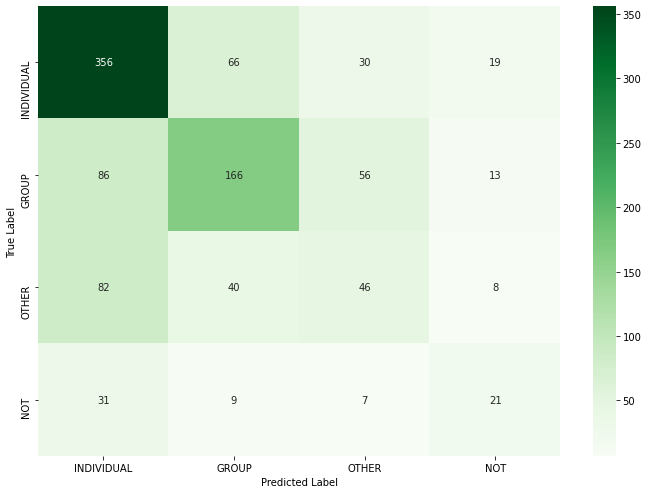

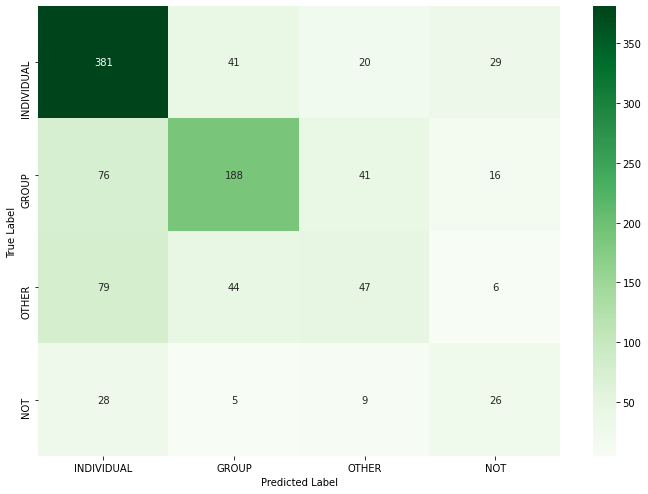

In [ ]:
confusion_heatmap(confusion_matrix(*parse(svm_base)), colors='Greens')
confusion_heatmap(confusion_matrix(*parse(svm_improved)), colors='Greens')

# BiLSTM

## Word Embeddings

In [25]:
# downloading the coosto model

WE_FILE = 'coosto.bin'

def download_word_embeddings():
    wordembeddings_url = 'https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin'

    r = requests.get(wordembeddings_url)

    if r.status_code == 200:
        with open(WE_FILE, 'wb') as wordembeddings_file:
            wordembeddings_file.write(
                r.content
            )
    
download_word_embeddings()

In [26]:
# loading coosto/word2vec:

def load_word_embeddings():
    return gensim.models.KeyedVectors.load_word2vec_format(WE_FILE, binary=True)

word_model = load_word_embeddings()

In [27]:
def _vectorize_data(data, wm):
    # turn the tokens into coosto vocab indices
    # these will be converted to embeddings in the Embedding layer
    vocab = wm.vocab
    keys = list(vocab.keys())

    final = []
    for tweet in data:
        final.append([keys.index(word) for word in tweet if vocab.get(word, None) is not None])
    return final

def vectorize_data(all_tweets, model):
    # pad so each vector is equal length (300)
    return pad_sequences(
        sequences=_vectorize_data(all_tweets, model),
        maxlen=model.vector_size,
        padding='post')

## Preparing Model

In [28]:
# setup architecture of BiLSTM

def _build_model(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(
    input_dim = embedding_matrix.shape[0],
    output_dim = embedding_matrix.shape[1], 
    input_length = input_length,
    weights = [embedding_matrix],
    trainable=False))
    
    model.add(Bidirectional(LSTM(150, recurrent_dropout=0.1))) # -> None, 300
    # model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1))) # -> None, 256
    # model.add(Bidirectional(LSTM(300, recurrent_dropout=0.1)))

    model.add(Dropout(0.25)) # -> None, 256
    model.add(Dense(64)) # -> None, 64
    model.add(Dropout(0.3)) # None, 64

    model.add(Dense(len(LABELS), activation='softmax')) # -> output should be the amount of labels we have for multi-class! (sigmoid)
    model.summary()
    return model


# simpler:
# def _build_model(embedding_matrix, input_length):
#     model = Sequential()
#     model.add(Embedding(
#         input_dim = embedding_matrix.shape[0],
#         output_dim = embedding_matrix.shape[1], 
#         input_length = input_length,
#         weights = [embedding_matrix],
#         trainable=False))
#     model.add(Bidirectional(LSTM(300)))
#     model.add(Dropout(0.2))
#     model.add(Dense(len(LABELS), activation='softmax')) # -> output should be the amount of labels we have for multi-class! (sigmoid)
#     model.summary()
#     return model

# two layers:
# def _build_model(embedding_matrix, input_length):
#     model = Sequential()
#     model.add(Embedding(
#         input_dim = embedding_matrix.shape[0],
#         output_dim = embedding_matrix.shape[1], 
#         input_length = input_length,
#         weights = [embedding_matrix],
#         trainable=False))
#     model.add(Bidirectional(LSTM(150, return_sequences=True, recurrent_dropout=0.15)))
#     model.add(Bidirectional(LSTM(150, recurrent_dropout=0.15)))
#     model.add(Dropout(0.25))
#     model.add(Dense(128))
#     model.add(Dropout(0.3))
#     model.add(Dense(len(LABELS), activation='softmax')) # -> output should be the amount of labels we have for multi-class! (sigmoid)
#     model.summary()
#     return model

def build_model(word_model):
    return _build_model(
        embedding_matrix=word_model.vectors,
        input_length=word_model.vector_size)

In [ ]:
def _run(model, epochs=20, batch_size=100):
    # compile and train the model
    model.compile(
        loss="sparse_categorical_crossentropy", # <- 4 classes
        optimizer='adam',
        metrics=[
                 'accuracy'
                 ])

    history = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_test, y_test), # todo: y_dev instead of test, keep unseen data!
        batch_size=batch_size,
        epochs=epochs)
    
    return model

def find_gpu():
    # check if GPU exists
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    return device_name

def find_cpu():
    # fallback to CPU
    return "/cpu:0"

def run(model, GPU=True, *a, **kw):
    # run the model (using GPU)
    device = (find_cpu if not GPU else find_gpu)()

    with tf.device(device):
        return _run(model, *a, **kw)

def bilstm_predict(model, x, label=False):
    # predict x with model
    result = np.argmax(model.predict(x), axis=-1)
    return [LABELS[r] for r in result] if label else result

def evaluate_report(model, test_x, test_y):
    # show report and confusion matrix of model on test or dev

    test_predictions = bilstm_predict(model, test_x)
    print(classification_report(test_y, test_predictions))
    print(confusion(test_y, test_predictions))
    return sklearn.metrics.accuracy_score(test_y, test_predictions)

## Running the Model

In [ ]:
# tutorial: https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc

bilstm_pipeline = [
                  # emoji,
                str.lower,
                  # clean_tweet,
                  # remove_mentions_full,
                remove_mentions,
                remove_urls,
                remove_hashtags,
                  # remove_punctuation,
                remove_numbers,

                  # tokenize_nltk,
                  # tokenize,
                word_tokenize,

                  # remove_stop_words,
                  # stem,
]

# baseline:
# bilstm_pipeline = [tokenize]

def preprocess_data_bilstm(df):
    # preprocess each Tweet and put it in a numpy array to vectorize afterwards
    return np.array([preprocess(x, bilstm_pipeline) for x in df.text])

# preproc. everything
all_tweets_train = preprocess_data_bilstm(train_df)
all_tweets_test = preprocess_data_bilstm(test_df)
all_tweets_eval = preprocess_data_bilstm(eval_df)

# vectorize everything
X_train = vectorize_data(all_tweets_train, word_model)
y_train = train_df.labels.values
X_test = vectorize_data(all_tweets_test, word_model)
y_test = test_df.labels.values
X_eval = vectorize_data(all_tweets_eval, word_model)
y_eval = eval_df.labels.values

In [ ]:
def find_optimal_bilstm(epochs=5):
    # show evaluation report after each epoch and save weights to drive
    # (not really used since keras prints val_accuracy after each epoch already)
    model = build_model(word_model)
    best_acc = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        model = run(model, epochs=1)
        acc = evaluate_report(model, X_test, y_test)
        if acc > best_acc:
            best_acc = acc
            acc = "%.4f" % round(acc, 4)
            print('new record!')
            f = f'bilstm-{epoch}-{acc}.h5'
            model.save(f)
            os.system(f'mv {f} {DRIVE}')
    
    print('best acc:', best_acc, f)
    return model

In [ ]:
# for x in range(1):
#     run(model, epochs=1)
#     evaluate_report(model, X_test, y_test)

# find_optimal_bilstm(3)

In [ ]:
model = build_model(word_model)
run(model, epochs=8) 
evaluate_report(model, X_test, y_test) # evaluate on dev
evaluate_report(model, X_eval, y_eval) # evaluate on test

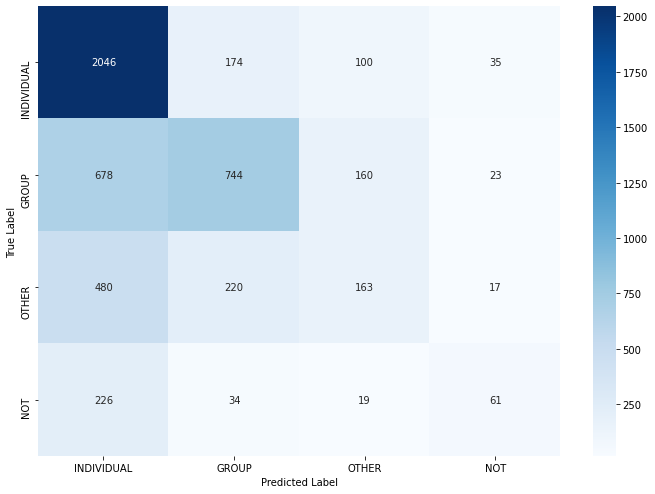

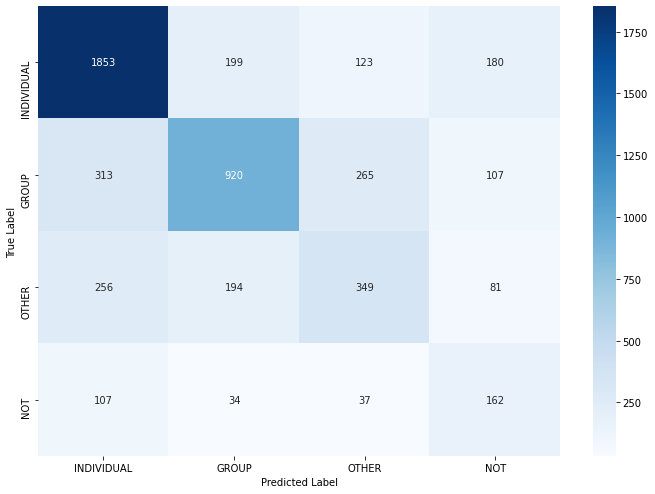

        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.5977         & 0.8688      & 0.7077        & 471      \\
GROUP        & 0.6375         & 0.4636      & 0.5327        & 321                      \\
OTHER        & 0.3662         & 0.1852      & 0.2342       & 176                     \\
NOT          & 0.4694        & 0.1794     & 0.2532       & 68 \\
accuracy     &           &        & 0.5819       & 1036                     \\
macro avg    & 0.5177        & 0.4243     & 0.4319       & 1036                     \\
weighted avg & 0.5623        & 0.5819     & 0.5432       & 1036                                   
             
        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.7381         & 0.7868      & 0.7587        & 471      \\
GROUP        & 0.6893         & 0.5732      & 0.6213        & 321                      \\
OTHER        & 0.4592         & 0.3966      & 0.4203       & 176                     \\
NOT          & 0.3104        & 0

In [ ]:
# saved scores:

# baseline: (split, 1 epoch)
bilstm_baseline_1 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.6387    0.8408    0.7259       471
       GROUP     0.6367    0.5078    0.5650       321
       OTHER     0.3767    0.3125    0.3416       176
         NOT     0.5714    0.1176    0.1951        68

    accuracy                         0.6004      1036
   macro avg     0.5559    0.4447    0.4569      1036
weighted avg     0.5892    0.6004    0.5759      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         396     43     31    1
GROUP              107    163     49    2
OTHER               73     45     55    3
NOT                 44      5     11    8
"""

bilstm_baseline_2 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.5800    0.8620    0.6934       471
       GROUP     0.6770    0.3396    0.4523       321
       OTHER     0.3459    0.2614    0.2977       176
         NOT     0.3571    0.2206    0.2727        68

    accuracy                         0.5560      1036
   macro avg     0.4900    0.4209    0.4290      1036
weighted avg     0.5557    0.5560    0.5239      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         406     19     30   16
GROUP              151    109     54    7
OTHER               98     28     46    4
NOT                 45      5      3   15
"""

bilstm_baseline_3 =  """
              precision    recall  f1-score   support

  INDIVIDUAL     0.5963    0.8811    0.7112       471
       GROUP     0.6284    0.5109    0.5636       321
       OTHER     0.4464    0.1420    0.2155       176
         NOT     0.4783    0.1618    0.2418        68

    accuracy                         0.5936      1036
   macro avg     0.5373    0.4240    0.4330      1036
weighted avg     0.5730    0.5936    0.5504      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         415     39     13    4
GROUP              137    164     17    3
OTHER               96     50     25    5
NOT                 48      8      1   11
"""

bilstm_baseline_4 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.5730    0.8917    0.6977       471
       GROUP     0.6130    0.4393    0.5118       321
       OTHER     0.2683    0.0625    0.1014       176
         NOT     0.5000    0.2353    0.3200        68

    accuracy                         0.5676      1036
   macro avg     0.4886    0.4072    0.4077      1036
weighted avg     0.5288    0.5676    0.5140      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         420     35      9    7
GROUP              154    141     20    6
OTHER              114     48     11    3
NOT                 45      6      1   16
"""

bilstm_baseline_5 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.6006    0.8684    0.7101       471
       GROUP     0.6326    0.5202    0.5709       321
       OTHER     0.3939    0.1477    0.2149       176
         NOT     0.4400    0.1618    0.2366        68

    accuracy                         0.5917      1036
   macro avg     0.5168    0.4245    0.4331      1036
weighted avg     0.5649    0.5917    0.5518      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         409     38     17    7
GROUP              129    167     20    5
OTHER               99     49     26    2
NOT                 44     10      3   11
"""

# final:

bilstm_final_1 = """
             precision    recall  f1-score   support
  INDIVIDUAL     0.7792    0.7495    0.7641       471
       GROUP     0.6530    0.6449    0.6489       321
       OTHER     0.4539    0.3920    0.4207       176
         NOT     0.3333    0.5588    0.4176        68

    accuracy                         0.6438      1036
   macro avg     0.5549    0.5863    0.5628      1036
weighted avg     0.6556    0.6438    0.6473      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         353     53     27   38
GROUP               44    207     49   21
OTHER               40     50     69   17
NOT                 16      7      7   38
"""

bilstm_final_2 ="""
             precision    recall  f1-score   support
  INDIVIDUAL     0.7468    0.7516    0.7492       471
       GROUP     0.7251    0.4766    0.5752       321
       OTHER     0.4057    0.4886    0.4433       176
         NOT     0.2518    0.5147    0.3382        68

    accuracy                         0.6062      1036
   macro avg     0.5324    0.5579    0.5265      1036
weighted avg     0.6497    0.6062    0.6163      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         354     24     39   54
GROUP               58    153     79   31
OTHER               45     26     86   19
NOT                 17      8      8   35
"""

bilstm_final_3 ="""
             precision    recall  f1-score   support
  INDIVIDUAL     0.7143    0.8386    0.7715       471
       GROUP     0.7045    0.5794    0.6359       321
       OTHER     0.4697    0.3523    0.4026       176
         NOT     0.3793    0.4853    0.4258        68

    accuracy                         0.6525      1036
   macro avg     0.5670    0.5639    0.5589      1036
weighted avg     0.6477    0.6525    0.6441      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         395     35     15   26
GROUP               72    186     48   15
OTHER               63     38     62   13
NOT                 23      5      7   33
"""

bilstm_final_4 ="""
             precision    recall  f1-score   support
  INDIVIDUAL     0.6683    0.8641    0.7537       471
       GROUP     0.7269    0.5140    0.6022       321
       OTHER     0.5229    0.3239    0.4000       176
         NOT     0.2747    0.3676    0.3145        68

    accuracy                         0.6313      1036
   macro avg     0.5482    0.5174    0.5176      1036
weighted avg     0.6359    0.6313    0.6178      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         407     26     12   26
GROUP              101    165     33   22
OTHER               71     30     57   18
NOT                 30      6      7   25
"""

bilstm_final_5 ="""
             precision    recall  f1-score   support
  INDIVIDUAL     0.7818    0.7304    0.7552       471
       GROUP     0.6372    0.6511    0.6441       321
       OTHER     0.4438    0.4261    0.4348       176
         NOT     0.3131    0.4559    0.3713        68

    accuracy                         0.6361      1036
   macro avg     0.5440    0.5659    0.5513      1036
weighted avg     0.6488    0.6361    0.6411      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         344     61     30   36
GROUP               38    209     56   18
OTHER               37     50     75   14
NOT                 21      8      8   31
"""

''


confusion_heatmap(confusion_matrix(
    *parse(bilstm_baseline_1, bilstm_baseline_2, bilstm_baseline_3, bilstm_baseline_4, bilstm_baseline_5)), colors='Blues')
confusion_heatmap(confusion_matrix(
    *parse(bilstm_final_1, bilstm_final_2, bilstm_final_3, bilstm_final_4, bilstm_final_5)), colors='Blues')

parse_report(bilstm_baseline_1, bilstm_baseline_2, bilstm_baseline_3, bilstm_baseline_4, bilstm_baseline_5)
parse_report(bilstm_final_1, bilstm_final_2, bilstm_final_3, bilstm_final_4, bilstm_final_5)

### Visualizing

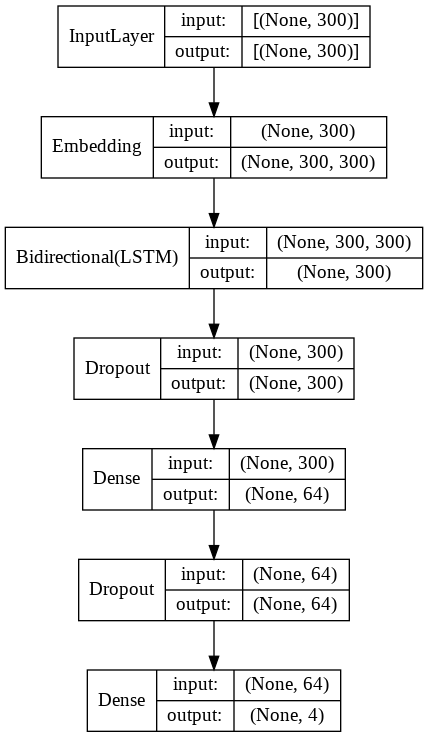

In [ ]:
# visualize: model
# model = build_model(word_model)

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB", # LR
    expand_nested=True,
    dpi=96,
)

### Saving/Loading
Can be used to store and load weights, and continue training

In [ ]:
model.save('bilstm.h5')

In [ ]:
model = tf.keras.models.load_model('bilstm.h5')
model.evaluate(X_test, y_test)

8/8 [==============================] - 3s 262ms/step - loss: 0.4679 - accuracy: 0.6245


[0.46792522072792053, 0.624454140663147]

In [ ]:
# run(model, epochs=1)
model.evaluate(X_test, y_test)
evaluate_report(model, X_test, y_test)

8/8 [==============================] - 2s 268ms/step - loss: 0.3396 - accuracy: 0.6550
              precision    recall  f1-score   support

  INDIVIDUAL     0.5328    1.0000    0.6952       122
       GROUP     0.0000    0.0000    0.0000        81
       OTHER     0.0000    0.0000    0.0000        26
         NOT     0.0000    0.0000    0.0000         0

   micro avg     0.5328    0.5328    0.5328       229
   macro avg     0.1332    0.2500    0.1738       229
weighted avg     0.2838    0.5328    0.3703       229



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT

## Functions

In [42]:
EPOCHS = 1

BERTje_baseline_config = {
    'name': 'BERTje baseline',

    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'train_batch_size': 8, # default 
    'learning_rate': 4e-5, # default
}

BERTje_config = {
    'name': 'BERTje',

    'model': 'GroNLP/bert-base-dutch-cased',
    'type': 'bert',
    'train_batch_size': 4,
    'learning_rate': 6e-5,
}

RobBERT_baseline_config = {
    'name': 'RobBERT baseline',

    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'train_batch_size': 8, # default
    'learning_rate': 4e-5, # default
}

RobBERT_config = {
    'name': 'RobBERT',

    'model': 'pdelobelle/robbert-v2-dutch-base',
    'type': 'roberta',
    'train_batch_size': 4,
    'learning_rate': 4e-5,
}


def train_bert(from_epoch=False, epochs=EPOCHS, config=BERTje_config):
    print('using model', config['name'])

    # Optional model configuration
    model_args = ClassificationArgs(
        overwrite_output_dir=True,

        do_lower_case=False, # BERTje is cased, so disable lowercase

        save_steps=-1, # save storage space

        train_batch_size=config['train_batch_size'], # played with 4, 16, default (8)
        learning_rate=config['learning_rate'], # played with 6e-5, 5e-5, 2e-5, 1e-5, default (4e-5)
        )

    model_args.num_train_epochs=epochs

    # allow to continue from previous model:
    model = "/content/outputs" if from_epoch else config['model']

    # Create a ClassificationModel
    model = ClassificationModel(
        config['type'], 
        model,

        num_labels=len(LABELS),
        args=model_args,

        use_cuda=True, # much faster to use GPU
    )

    # Train the model
    if epochs:
        model.train_model(train_df)

    return model

In [31]:
def load_bert():
    # load BERT from /content/outputs without training
    return train_bert(1, 0)

In [32]:
def evaluate_bert(model, df=None):
    # run evaluation for BERT

    metrics = {
        'accuracy': sklearn.metrics.accuracy_score,
        'all': classification_report,
        'confusion': confusion,
    }

    if df is None:
        df = test_df

    result, model_outputs, wrong_predictions = model.eval_model(df, **metrics)

    return result

In [33]:
def store_bert(acc, info):
    # can be used to store model to drive,
    # (disabled for speed)
    return False
    
    acc = "%.4f" % round(acc, 4) # <- round with trailing 0/padding at the end
    os.system('rm outputs/checkpoint-* -r')
    os.system(f'zip -r BERT-{acc}-model.zip outputs')
    os.system(f'mv BERT-{acc}-model.zip {DRIVE}')
    with open(f'{DRIVE}BERT-{acc}-info.txt', 'w') as f:
        yaml.dump(info, f)

In [34]:
def find_optimal_bert(n=5, _from=0, _save=True, config=None):
    # run evaluation after each epoch to find the optimal amount of epochs

    best_acc = 0
    for epoch in range(_from, n+_from):
        print(f'epoch {epoch+1}')
        model = train_bert(epoch, config=config) # epoch 0 = new, 1+ = continue
        scores = evaluate_bert(model)
        if scores['accuracy'] > best_acc:
            print('high score!')
            best_acc = round(scores['accuracy'], 4)
            if _save:
                store_bert(best_acc, {'epoch': epoch + 1, 'acc': str(scores['accuracy']), 'now': str(datetime.datetime.utcnow())})
        print(scores['accuracy'])
        print(scores['all'])

    print('done', best_acc)

## Using

In [44]:
# BERTje baseline test

for _ in range(5):
    b_model = train_bert(0, 1, config=BERTje_baseline_config)
    b_eval = evaluate_bert(b_model, eval_df)
    print(b_eval['all'])
    print(b_eval['confusion'])

In [ ]:
# BERTje (dev)
find_optimal_bert(10, config=BERTje_config)

In [38]:
# BERTje (test)
for _ in range(5):
    # 5 runs for test
    print(_)
    b_model = train_bert(0, 3, config=BERTje_config) # new model with 3 epochs
    b_eval = evaluate_bert(b_model, eval_df)
    print(b_eval['all'])
    print(b_eval['confusion'])

In [39]:
# RobBERT baseline test

for _ in range(5):
    b_model = train_bert(0, 1, config=RobBERT_baseline_config)
    b_eval = evaluate_bert(b_model, eval_df)
    print(b_eval['all'])
    print(b_eval['confusion'])

In [ ]:
# RobBERT (dev)
find_optimal_bert(10, config=RobBERT_config)

In [ ]:
# RobBERT (test)
eval_df_robbert = eval_df.copy()
for i, tweet in eval_df_robbert.iterrows():
    # remove newlines for RobBERT
    eval_df_robbert.loc[i, 'text'] = tweet.text.replace('\n', ' ')

for _ in range(5):
    # 5 runs for test
    print(_)
    b_model = train_bert(False, 4, config=RobBERT_config) # epoch 0 = new, 1+ = continue; run 1 epoch
    b_eval = evaluate_bert(b_model, eval_df_robbert)
    print(b_eval['all'])
    print(b_eval['confusion'])

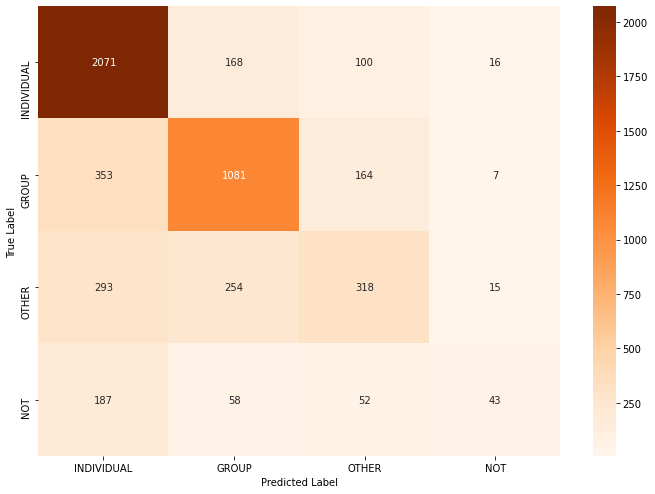

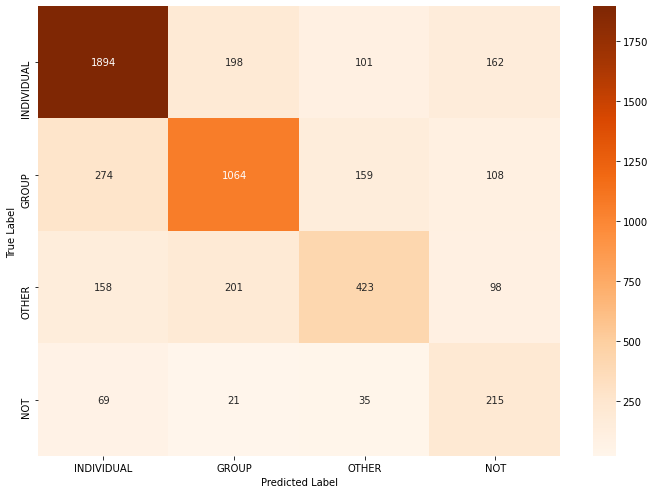

        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.7148         & 0.8794      & 0.7879        & 471      \\
GROUP        & 0.6952         & 0.6735      & 0.6824        & 321                      \\
OTHER        & 0.5026         & 0.3614      & 0.4197       & 176                     \\
NOT          & 0.5449        & 0.1265     & 0.2035       & 68 \\
accuracy     &           &        & 0.6782       & 1036                     \\
macro avg    & 0.6144        & 0.5102     & 0.5234       & 1036                     \\
weighted avg & 0.6615        & 0.6782     & 0.6543       & 1036                                   
             
        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.7911         & 0.8042      & 0.7975        & 471      \\
GROUP        & 0.717         & 0.6629      & 0.6887        & 321                      \\
OTHER        & 0.5911         & 0.4807      & 0.5296       & 176                     \\
NOT          & 0.3689        & 0.

In [ ]:
# BERTje saved scores

bert_base_1 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.6822    0.9023    0.7770       471
       GROUP     0.7113    0.6293    0.6678       321
       OTHER     0.5043    0.3295    0.3986       176
         NOT     0.7143    0.1471    0.2439        68

    accuracy                         0.6708      1036
   macro avg     0.6530    0.5021    0.5218      1036
weighted avg     0.6631    0.6708    0.6439      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         425     26     18    2
GROUP               88    202     30    1
OTHER               71     46     58    1
NOT                 39     10      9   10
"""

bert_base_2 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.6941    0.8960    0.7822       471
       GROUP     0.7204    0.6262    0.6700       321
       OTHER     0.5036    0.3920    0.4409       176
         NOT     0.6667    0.1176    0.2000        68

    accuracy                         0.6757      1036
   macro avg     0.6462    0.5080    0.5233      1036
weighted avg     0.6681    0.6757    0.6512      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         422     28     19    2
GROUP               81    201     38    1
OTHER               63     43     69    1
NOT                 42      7     11    8
"""

bert_base_3 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7605    0.8493    0.8024       471
       GROUP     0.6469    0.7477    0.6936       321
       OTHER     0.5126    0.3466    0.4136       176
         NOT     0.5500    0.1618    0.2500        68

    accuracy                         0.6873      1036
   macro avg     0.6175    0.5263    0.5399      1036
weighted avg     0.6694    0.6873    0.6664      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         400     51     18    2
GROUP               53    240     27    1
OTHER               44     65     61    6
NOT                 29     15     13   11
"""

bert_base_4 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7123    0.8832    0.7886       471
       GROUP     0.6824    0.6760    0.6792       321
       OTHER     0.5207    0.3580    0.4242       176
         NOT     0.3846    0.0735    0.1235        68

    accuracy                         0.6766      1036
   macro avg     0.5750    0.4977    0.5039      1036
weighted avg     0.6490    0.6766    0.6492      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         416     34     18    3
GROUP               72    217     30    2
OTHER               56     54     63    3
NOT                 40     13     10    5
"""

bert_base_5 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7247    0.8662    0.7892       471
       GROUP     0.7152    0.6885    0.7016       321
       OTHER     0.4718    0.3807    0.4214       176
         NOT     0.4091    0.1324    0.2000        68

    accuracy                         0.6805      1036
   macro avg     0.5802    0.5169    0.5280      1036
weighted avg     0.6581    0.6805    0.6609      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         408     29     27    7
GROUP               59    221     39    2
OTHER               59     46     67    4
NOT                 37     13      9    9
"""

bert_improved_1 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.8017    0.7813    0.7914       471
       GROUP     0.7097    0.6854    0.6973       321
       OTHER     0.5584    0.4886    0.5212       176
         NOT     0.3717    0.6176    0.4641        68

    accuracy                         0.6911      1036
   macro avg     0.6104    0.6432    0.6185      1036
weighted avg     0.7037    0.6911    0.6949      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         368     45     26   32
GROUP               51    220     31   19
OTHER               29     41     86   20
NOT                 11      4     11   42
"""

bert_improved_2 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7695    0.8153    0.7918       471
       GROUP     0.7235    0.6604    0.6906       321
       OTHER     0.6165    0.4659    0.5307       176
         NOT     0.3604    0.5882    0.4469        68

    accuracy                         0.6931      1036
   macro avg     0.6175    0.6325    0.6150      1036
weighted avg     0.7024    0.6931    0.6934      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         384     37     18   32
GROUP               62    212     29   18
OTHER               32     41     82   21
NOT                 21      3      4   40
"""

bert_improved_3 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.8042    0.8195    0.8118       471
       GROUP     0.7110    0.6667    0.6881       321
       OTHER     0.6194    0.4716    0.5355       176
         NOT     0.3884    0.6912    0.4974        68

    accuracy                         0.7046      1036
   macro avg     0.6307    0.6622    0.6332      1036
weighted avg     0.7166    0.7046    0.7059      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         386     39     19   27
GROUP               55    214     26   26
OTHER               29     43     83   21
NOT                 10      5      6   47
"""

bert_improved_4 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7921    0.8089    0.8004       471
       GROUP     0.7122    0.6168    0.6611       321
       OTHER     0.5484    0.4830    0.5136       176
         NOT     0.3361    0.6029    0.4316        68

    accuracy                         0.6805      1036
   macro avg     0.5972    0.6279    0.6017      1036
weighted avg     0.6960    0.6805    0.6843      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         381     37     19   34
GROUP               58    198     42   23
OTHER               28     39     85   24
NOT                 14      4      9   41
"""

bert_improved_5 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7878    0.7962    0.7920       471
       GROUP     0.7285    0.6854    0.7063       321
       OTHER     0.6127    0.4943    0.5472       176
         NOT     0.3879    0.6618    0.4891        68

    accuracy                         0.7017      1036
   macro avg     0.6292    0.6594    0.6336      1036
weighted avg     0.7134    0.7017    0.7040      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         375     40     19   37
GROUP               48    220     31   22
OTHER               40     37     87   12
NOT                 13      5      5   45

"""

confusion_heatmap(confusion_matrix(
    *parse(bert_base_1, bert_base_2, bert_base_3, bert_base_4, bert_base_5)), colors='Oranges')
confusion_heatmap(confusion_matrix(
    *parse(bert_improved_1, bert_improved_2, bert_improved_3, bert_improved_4, bert_improved_5)), colors='Oranges')


parse_report(bert_base_1, bert_base_2, bert_base_3, bert_base_4, bert_base_5)
parse_report(bert_improved_1, bert_improved_2, bert_improved_3, bert_improved_4, bert_improved_5)

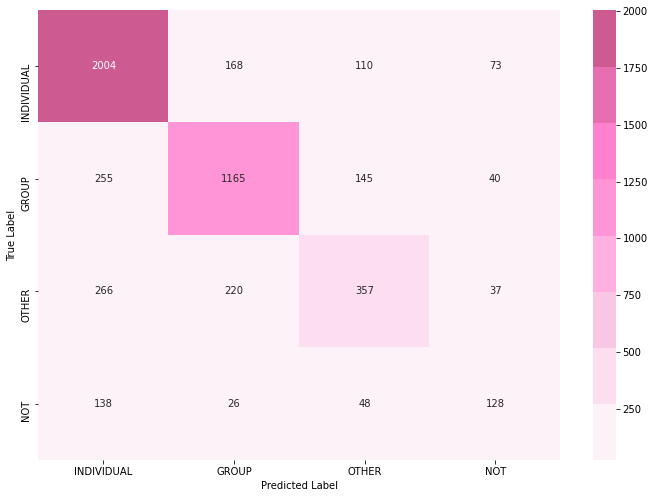

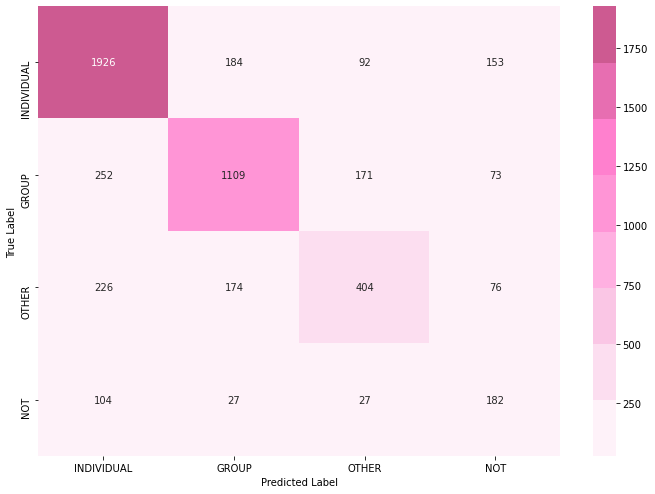

        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.7527         & 0.8509      & 0.7987        & 471      \\
GROUP        & 0.7381         & 0.7259      & 0.7317        & 321                      \\
OTHER        & 0.5428         & 0.4057      & 0.4636       & 176                     \\
NOT          & 0.4752        & 0.3765     & 0.4104       & 68 \\
accuracy     &           &        & 0.7054       & 1036                     \\
macro avg    & 0.6272        & 0.5897     & 0.6011       & 1036                     \\
weighted avg & 0.6943        & 0.7054     & 0.6955       & 1036                                   
             
        & precision & recall & f1-score & support \\ \hline
INDIVIDUAL   & 0.7682         & 0.8178      & 0.7921        & 471      \\
GROUP        & 0.7425         & 0.691      & 0.7157        & 321                      \\
OTHER        & 0.5848         & 0.4591      & 0.5125       & 176                     \\
NOT          & 0.376        & 0.5

In [ ]:
# RobBERT scores saved

robbert_base_1 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7405    0.8662    0.7984       471
       GROUP     0.7492    0.7072    0.7276       321
       OTHER     0.5522    0.4205    0.4774       176
         NOT     0.5208    0.3676    0.4310        68

    accuracy                         0.7085      1036
   macro avg     0.6407    0.5904    0.6086      1036
weighted avg     0.6968    0.7085    0.6978      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         408     32     22    9
GROUP               58    227     27    9
OTHER               54     43     74    5
NOT                 31      1     11   25
"""

robbert_base_2 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7650    0.8365    0.7992       471
       GROUP     0.7256    0.7414    0.7334       321
       OTHER     0.5520    0.3920    0.4585       176
         NOT     0.4265    0.4265    0.4265        68

    accuracy                         0.7046      1036
   macro avg     0.6173    0.5991    0.6044      1036
weighted avg     0.6944    0.7046    0.6965      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         394     37     20   20
GROUP               45    238     27   11
OTHER               52     47     69    8
NOT                 24      6      9   29
"""

robbert_base_3 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7588    0.8684    0.8099       471
       GROUP     0.7316    0.7134    0.7224       321
       OTHER     0.5000    0.4148    0.4534       176
         NOT     0.4737    0.2647    0.3396        68

    accuracy                         0.7037      1036
   macro avg     0.6160    0.5653    0.5813      1036
weighted avg     0.6877    0.7037    0.6914      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         409     30     24    8
GROUP               49    229     38    5
OTHER               50     46     73    7
NOT                 31      8     11   18
"""

robbert_base_4 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7490    0.8365    0.7904       471
       GROUP     0.7372    0.7601    0.7485       321
       OTHER     0.5324    0.4205    0.4698       176
         NOT     0.5500    0.3235    0.4074        68

    accuracy                         0.7085      1036
   macro avg     0.6421    0.5852    0.6040      1036
weighted avg     0.6955    0.7085    0.6978      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         394     36     27   14
GROUP               49    244     26    2
OTHER               57     43     74    2
NOT                 26      8     12   22
"""

robbert_base_5 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7500    0.8471    0.7956       471
       GROUP     0.7467    0.7072    0.7264       321
       OTHER     0.5776    0.3807    0.4589       176
         NOT     0.4048    0.5000    0.4474        68

    accuracy                         0.7017      1036
   macro avg     0.6198    0.6087    0.6071      1036
weighted avg     0.6970    0.7017    0.6941      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         399     33     17   22
GROUP               54    227     27   13
OTHER               53     41     67   15
NOT                 26      3      5   34
"""

robbert_improved_1 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7759    0.7941    0.7849       471
       GROUP     0.7308    0.7103    0.7204       321
       OTHER     0.5887    0.4716    0.5237       176
         NOT     0.3663    0.5441    0.4379        68

    accuracy                         0.6969      1036
   macro avg     0.6154    0.6300    0.6167      1036
weighted avg     0.7032    0.6969    0.6977      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         374     38     22   37
GROUP               47    228     33   13
OTHER               41     38     83   14
NOT                 20      8      3   37
"""

robbert_improved_2 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7553    0.8323    0.7919       471
       GROUP     0.7441    0.6885    0.7152       321
       OTHER     0.5814    0.4261    0.4918       176
         NOT     0.3736    0.5000    0.4277        68

    accuracy                         0.6969      1036
   macro avg     0.6136    0.6117    0.6067      1036
weighted avg     0.6972    0.6969    0.6933      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         392     34     17   28
GROUP               55    221     31   14
OTHER               50     36     75   15
NOT                 22      6      6   34
"""

robbert_improved_3 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7739    0.8068    0.7900       471
       GROUP     0.7491    0.6698    0.7072       321
       OTHER     0.5385    0.5170    0.5275       176
         NOT     0.3820    0.5000    0.4331        68

    accuracy                         0.6950      1036
   macro avg     0.6109    0.6234    0.6145      1036
weighted avg     0.7005    0.6950    0.6964      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         380     38     24   29
GROUP               49    215     46   11
OTHER               41     29     91   15
NOT                 21      5      8   34
"""

robbert_improved_4 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7782    0.8195    0.7983       471
       GROUP     0.7483    0.6947    0.7205       321
       OTHER     0.6087    0.4773    0.5350       176
         NOT     0.3846    0.5882    0.4651        68

    accuracy                         0.7075      1036
   macro avg     0.6300    0.6449    0.6298      1036
weighted avg     0.7143    0.7075    0.7076      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         386     39     15   31
GROUP               49    223     32   17
OTHER               44     32     84   16
NOT                 17      4      7   40
"""

robbert_improved_5 = """
              precision    recall  f1-score   support

  INDIVIDUAL     0.7577    0.8365    0.7952       471
       GROUP     0.7400    0.6916    0.7150       321
       OTHER     0.6068    0.4034    0.4846       176
         NOT     0.3737    0.5441    0.4431        68

    accuracy                         0.6988      1036
   macro avg     0.6196    0.6189    0.6095      1036
weighted avg     0.7014    0.6988    0.6945      1036

confusion:

            INDIVIDUAL  GROUP  OTHER  NOT
INDIVIDUAL         394     35     14   28
GROUP               52    222     29   18
OTHER               50     39     71   16
NOT                 24      4      3   37
"""


# https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
confusion_heatmap(confusion_matrix(
    *parse(robbert_base_1, robbert_base_2, robbert_base_3, robbert_base_4, robbert_base_5)), 
    colors=['#fef2f9', '#fcdef0', '#fac6e5', '#ffb0e1', '#ff95d6', '#ff80ce', '#e76eb1', '#cd5a91'])

confusion_heatmap(confusion_matrix(
    *parse(robbert_improved_1, robbert_improved_2, robbert_improved_3, robbert_improved_4, robbert_improved_5)), 
    colors=['#fef2f9', '#fcdef0', '#fac6e5', '#ffb0e1', '#ff95d6', '#ff80ce', '#e76eb1', '#cd5a91'])

parse_report(robbert_base_1, robbert_base_2, robbert_base_3, robbert_base_4, robbert_base_5)
parse_report(robbert_improved_1, robbert_improved_2, robbert_improved_3, robbert_improved_4, robbert_improved_5)